In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

# Dataset preparation

### Loading MNIST

In [2]:
# Subtracts the pre-calculated mean of training set from train, validation and test set.
transform = T.Compose([T.ToTensor(), T.Normalize((0.13087,), (1,))])

# Dataset
mnist_train = dset.MNIST('../datasets', train=True, download=True, transform=transform)
mnist_test = dset.MNIST('../datasets', train=False, download=True, transform=transform)

# DataLoaders
num_train = 48000
loader_train = DataLoader(mnist_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(num_train)))
loader_val = DataLoader(mnist_train, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(num_train, 60000)))
loader_test = DataLoader(mnist_test, batch_size=64)##

# Measure mean of training set
# sum_ = 0
# for data, label in loader_train:
#     sum_ += np.sum(data.numpy(), axis=(0,2,3))
# avg = sum_/(48000*28*28)
# print(avg) # 0.13087

### Visualizing the data

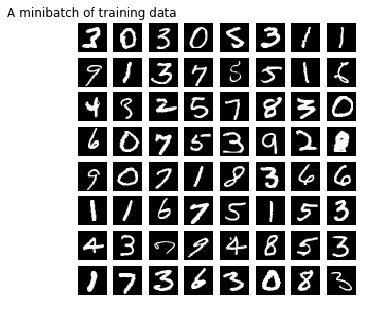

In [3]:
data, label = iter(loader_train).next()
data = data.numpy()

plt.rcParams['figure.figsize'] = [5, 5]

for i in range(8):
    for j in range(8):
        plt_idx = i * 8 + j + 1
        ax = plt.subplot(8, 8, plt_idx)
        plt.imshow(data[j+(i*8),0], cmap='gray')
        plt.axis('off')
        if i == 0 and j == 0:
            plt.title('A minibatch of training data')
plt.show()

### Setting up GPU

In [4]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('Using GPU!') if use_cuda else print('Using CPU!')

Using GPU!
